<IPython.core.display.Javascript object>


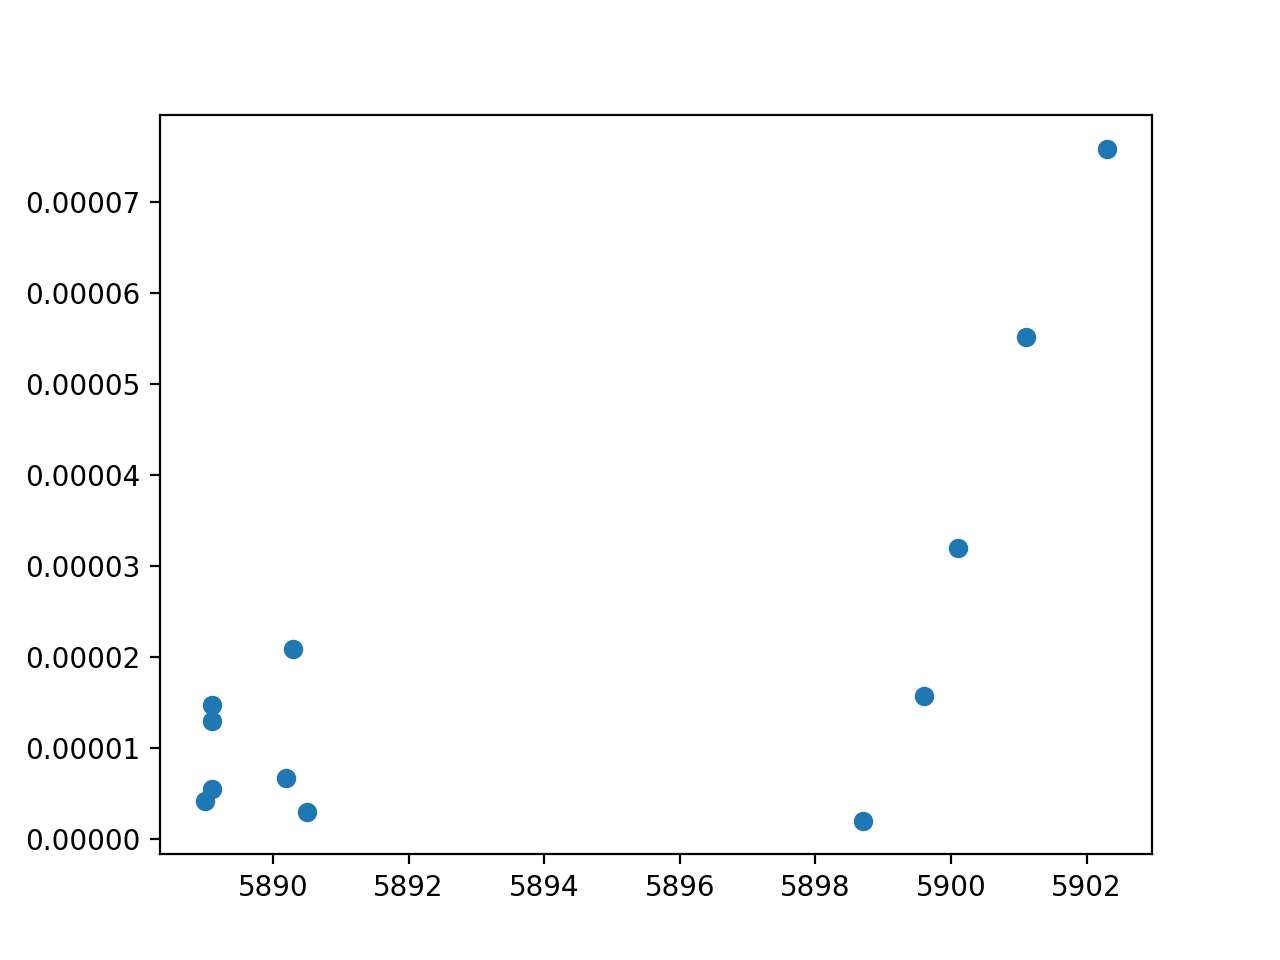

<IPython.core.display.Javascript object>


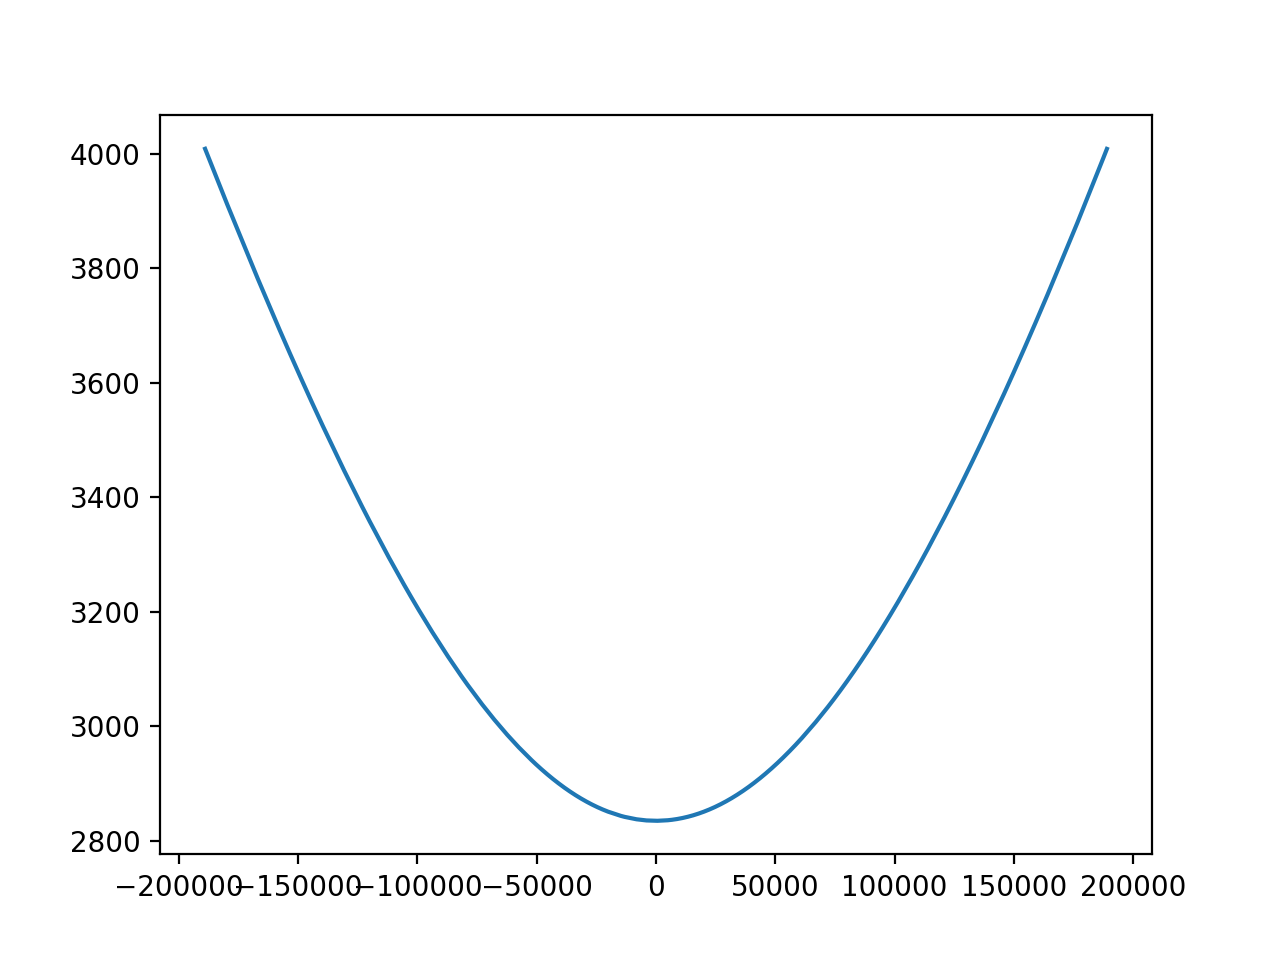

(6672,)

In [1]:
%matplotlib notebook
import glob
import h5py
import ipywidgets
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.interpolate import splrep, splev

C = 137.036
OMEGA =  5900 / 27.211

nt = 10000
dt = 0.01e-15 / 2.418884326505e-17
freq = np.fft.fftshift(np.fft.fftfreq(nt, dt)*2.0*np.pi*27.211)

def get_fwhm(xaxis, values):
    spline = splrep(xaxis, values)
    hm = 0.5*np.amax(values)
    index = np.argmax(values)
    a = optimize.bisect(lambda x: splev(x, spline)-hm, 
                        xaxis[0], xaxis[index])
    b = optimize.bisect(lambda x: splev(x, spline)-hm, 
                        xaxis[index], xaxis[-1])
    return b - a

dipole = [0.008707,
          0.007426,
          0.005651,
          0.004566,
          0.003958,
          0.003836,
          0.003590,
          0.002587,
          0.002340,
          0.002035,
          0.001728,
          0.001406]

omega = [5902.3,
         5901.1,
         5900.1,
         5890.3,
         5899.6,
         5889.1,
         5889.1,
         5890.2,
         5889.1,
         5889.0,
         5890.5,
         5898.7]

plt.figure()
plt.plot(omega, np.array(dipole)**2, 'o')
omega = np.array(omega)

z, focus = np.loadtxt('focus.dat', unpack=True)
plt.figure()
plt.plot(z, focus)
focus.shape

## Average spectrum

172


<IPython.core.display.Javascript object>


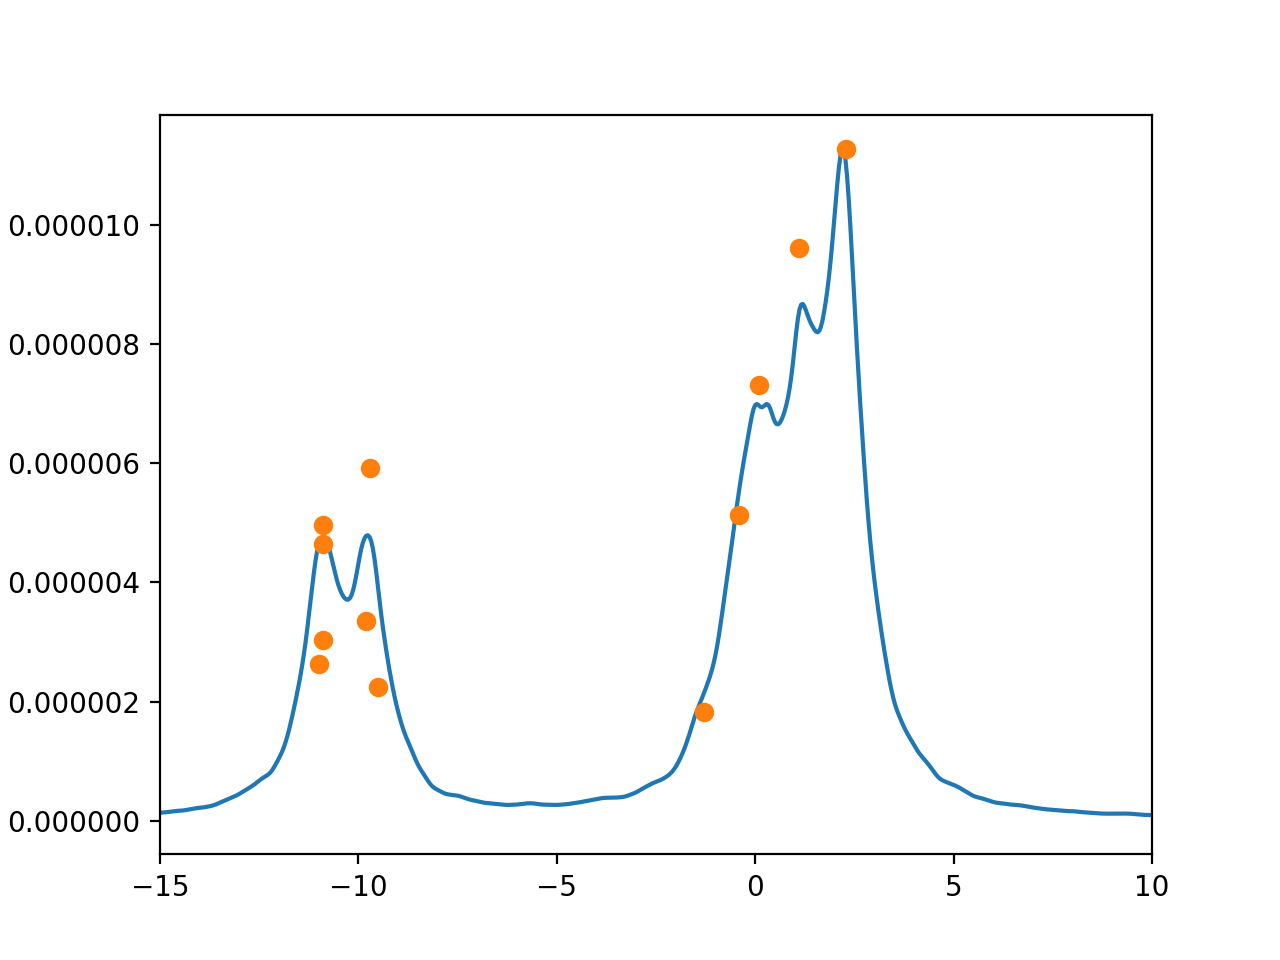

(-15.0, 10.0)

In [2]:
files = sorted(glob.glob('/Users/weninc/xrl/data/data*.h5'))[:-2]
print(len(files))
avg = np.zeros(10000)

omega_svea = 5900.0

for f in files:
    with h5py.File(f, 'r') as fh:
        avg += np.fft.fftshift(np.abs(np.fft.fft(fh['field'][0].conj()))**2)
        
plt.figure()
nt = 10000
dt = 0.01e-15 / 2.418884326505e-17
freq = np.fft.fftshift(np.fft.fftfreq(nt, dt)*2.0*np.pi*27.211)
plt.plot(freq, avg)
factor = np.amax(avg) / np.amax(dipole)
plt.plot(omega - omega_svea, np.array(dipole) * factor, 'o')
plt.xlim(-15.0, 10.0)

## Gain curve

172


<IPython.core.display.Javascript object>


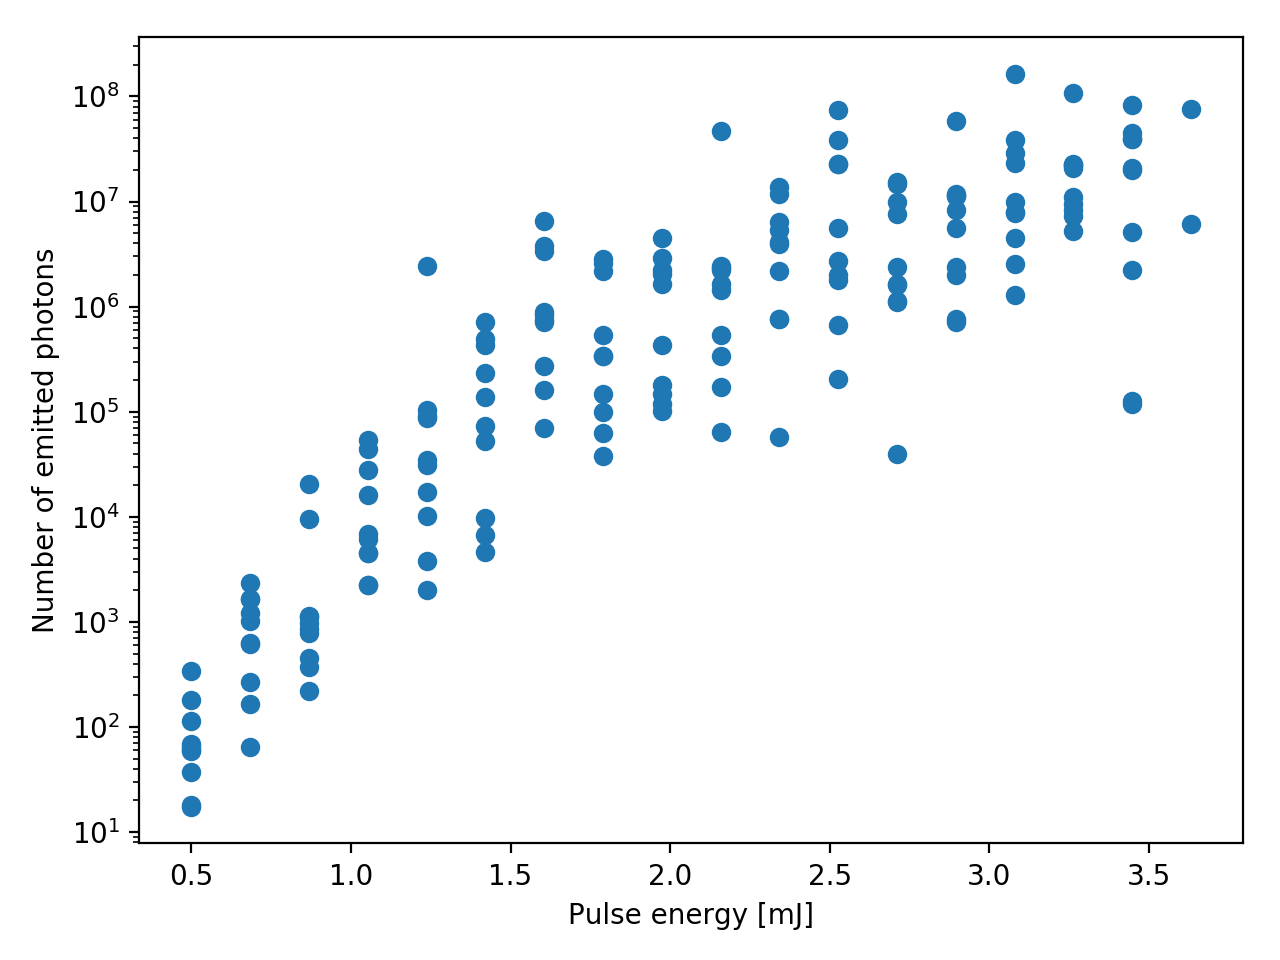

<IPython.core.display.Javascript object>


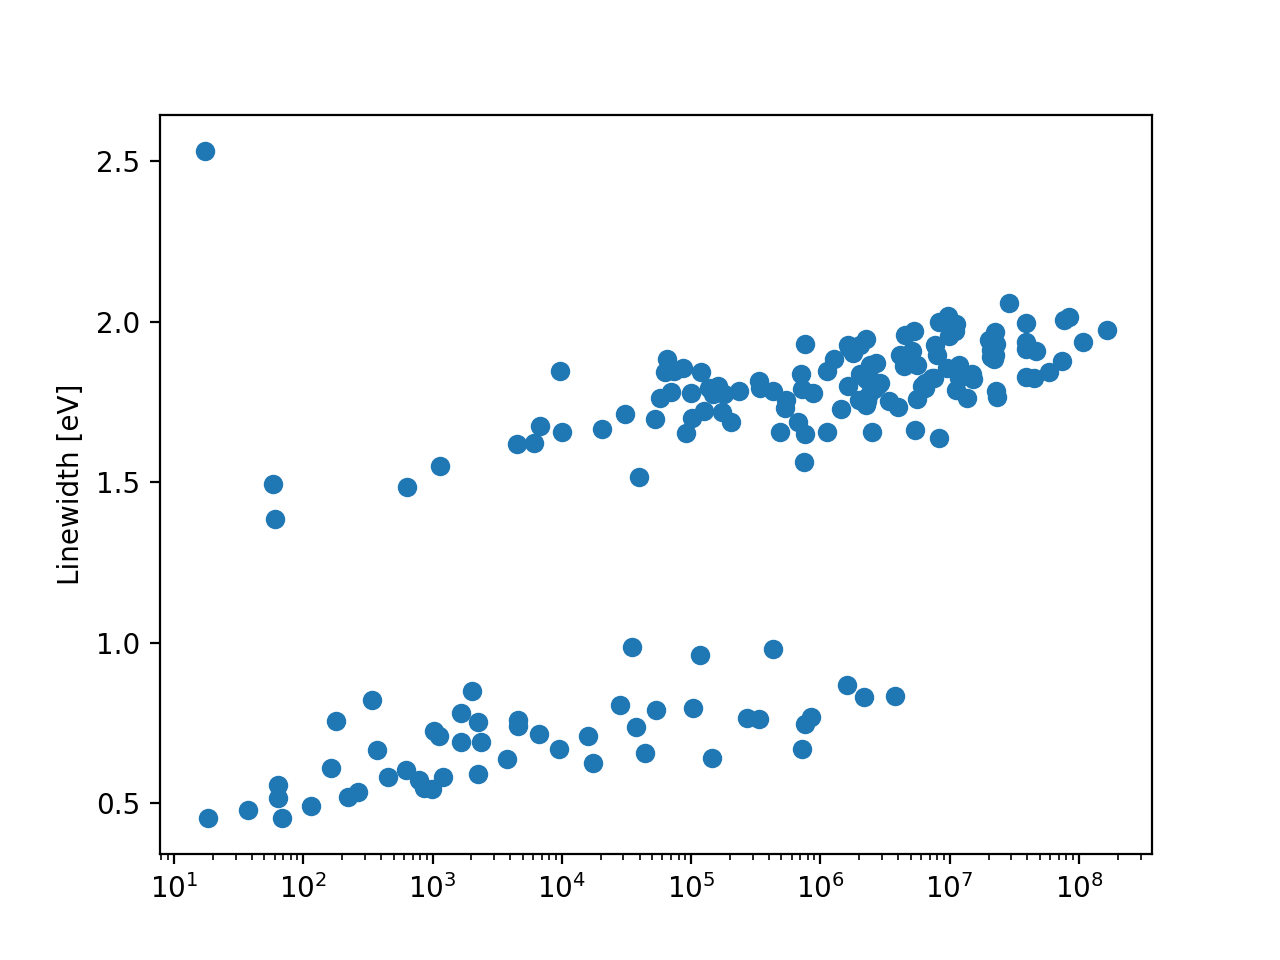

<IPython.core.display.Javascript object>


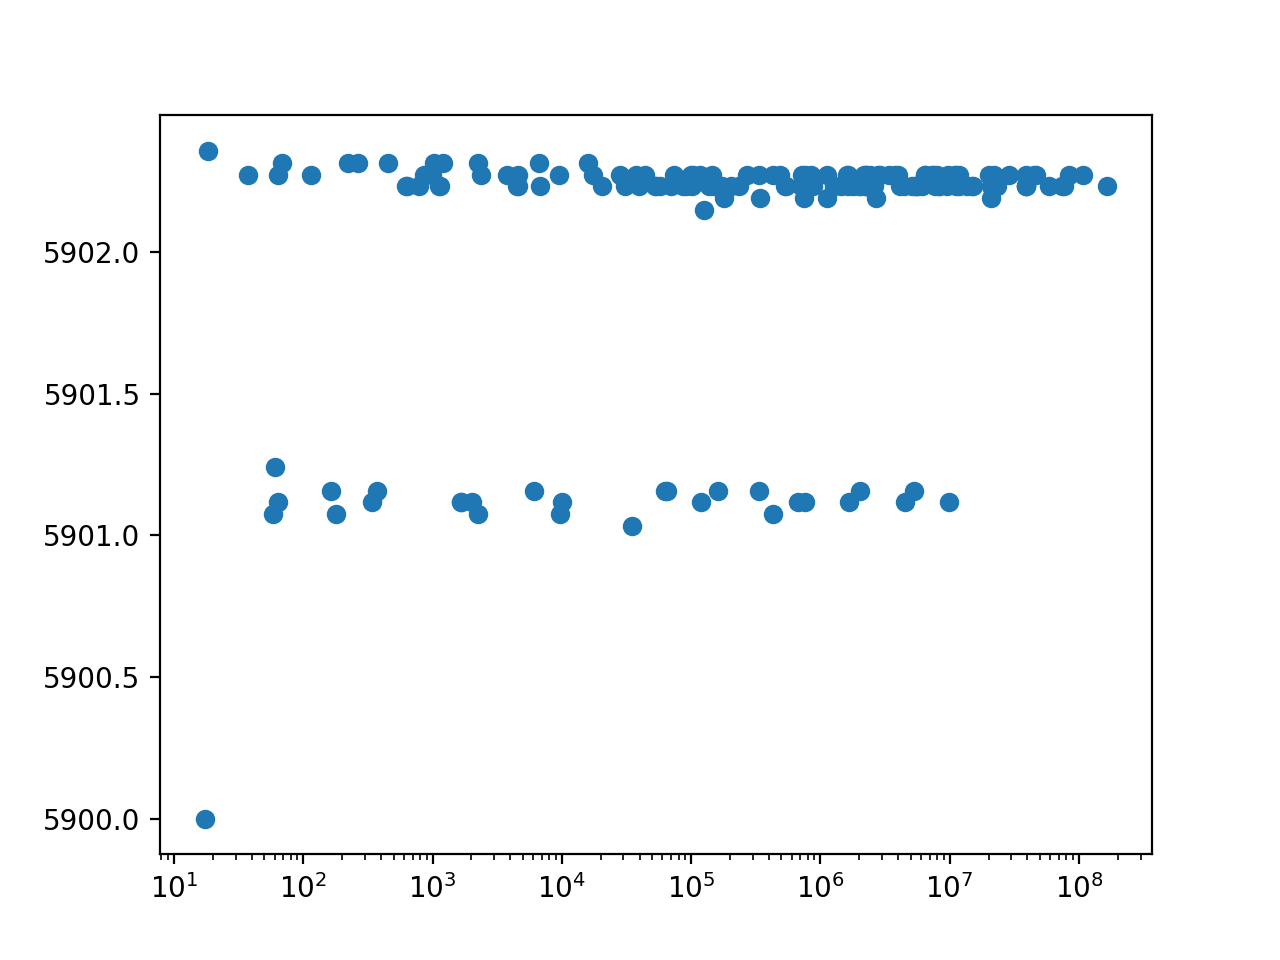

In [3]:
files = sorted(glob.glob('/Users/weninc/xrl/data/data*.h5'))[:-2]
print(len(files))

nph = []
xfel = []
spectra = []

for f in files:
    with h5py.File(f, 'r') as fh:
        rfocus = fh['para'].attrs['rfocus'][0]
        dt = fh['para'].attrs['dt'][0]
        intensity = C / (8.0*np.pi) * np.abs(fh['field'].value)**2
        nph.append(np.sum(intensity[-1]*dt)*rfocus**2*np.pi / OMEGA)
        xfel.append(np.sum(fh['xfel'][0]*dt)*focus[0]**2*np.pi)
        spectra.append(np.fft.fftshift(np.abs(np.fft.fft(fh['field'][-1].conj()))**2))
xfel = np.array(xfel)

plt.figure()
plt.scatter(xfel*1.6e-19*6.6e3*1.0e3, nph)
plt.yscale('log')
plt.xlabel('Pulse energy [mJ]')
plt.ylabel('Number of emitted photons')
plt.tight_layout()
plt.savefig('gain-plot.png')
np.savetxt('gain-data.txt', np.column_stack((xfel*1.6e-19*6.6e3*1.0e3, nph)))

plt.figure()
plt.scatter(nph, [get_fwhm(freq, spec) for spec in spectra])
plt.ylabel('Linewidth [eV]')
plt.xscale('log')

plt.figure()
plt.scatter(nph, 5900.0 + freq[np.argmax(spectra, axis=1)])
plt.xscale('log')

## Single shot

In [5]:
#fh = h5py.File('/Users/weninc/xrl/data/data-5fs-00.h5', 'r')
fh = h5py.File('/Users/weninc/xrl/data/data-17-00.h5', 'r')
rfocus = fh['para'].attrs['rfocus'][0]
dt = fh['para'].attrs['dt'][0]
omega_svea = fh['para'].attrs['omega_svea'][0] * 27.211

In [14]:
pulse_energy = 2.0e-3
'%.2e' %(pulse_energy/1.6e-19 / 6.6e3)

'1.89e+12'

<IPython.core.display.Javascript object>


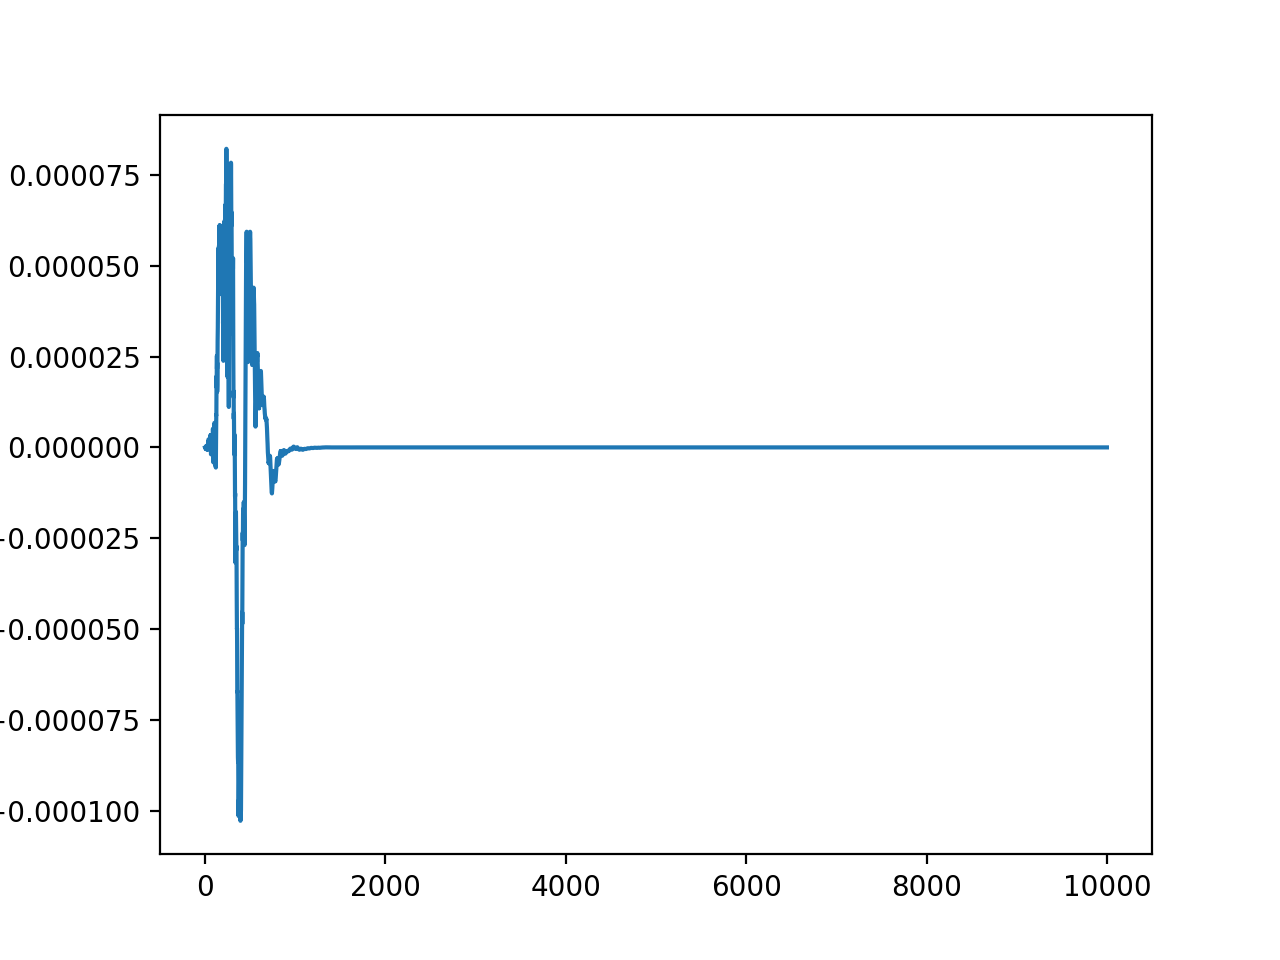

/Users/weninc/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [6]:
plt.figure()
plt.plot(fh['field'][20])

<IPython.core.display.Javascript object>


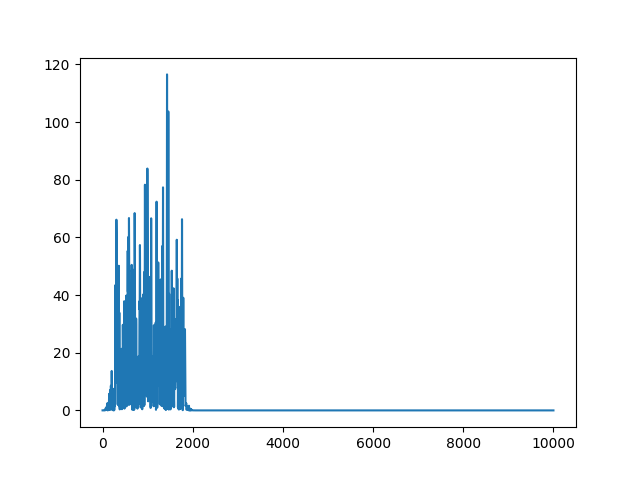

In [46]:
plt.figure()
#plt.plot(fh['groundstate'][40])
plt.plot(fh['xfel'][25])

<IPython.core.display.Javascript object>


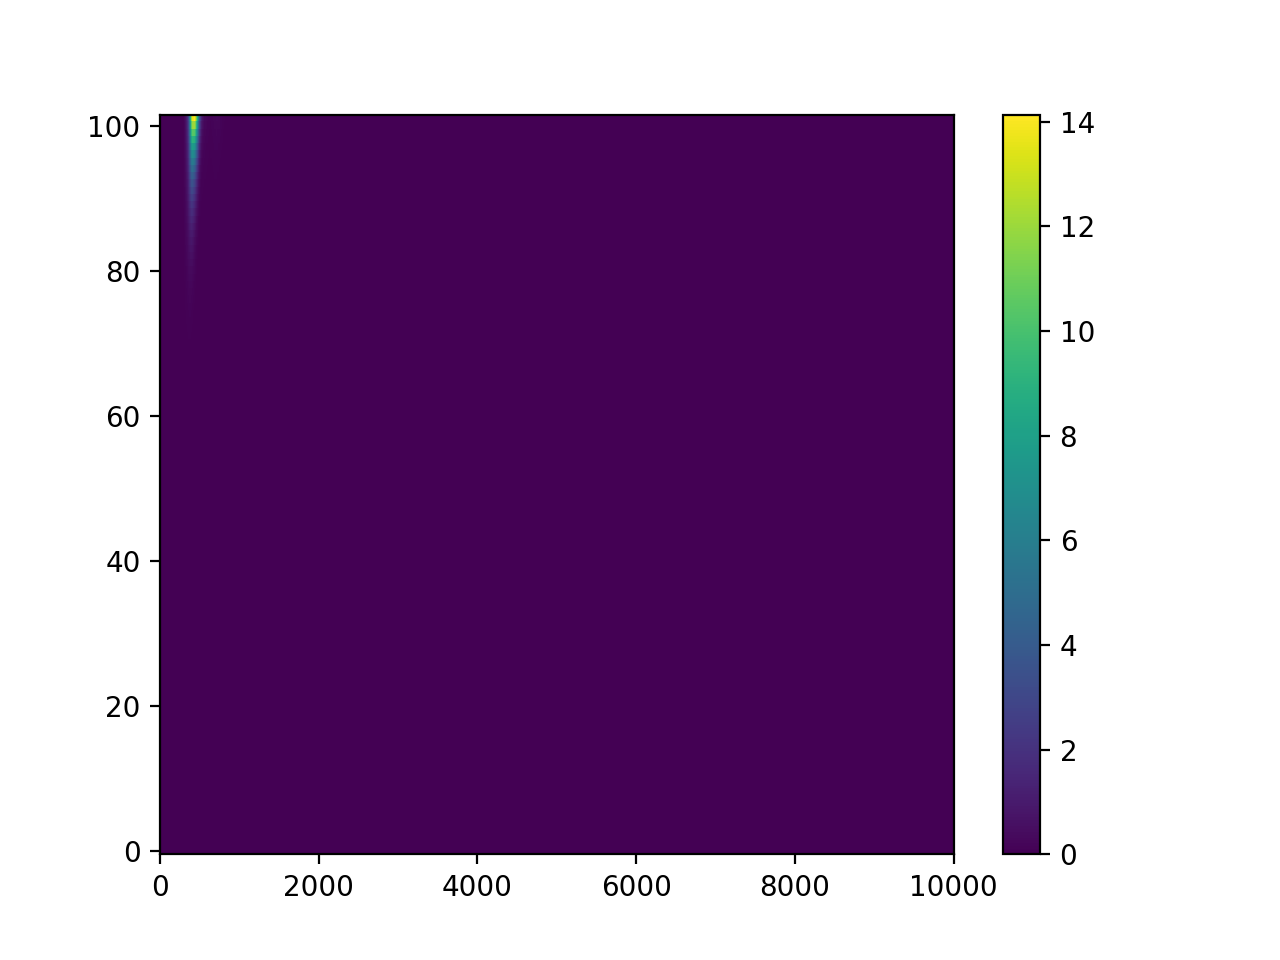

<IPython.core.display.Javascript object>


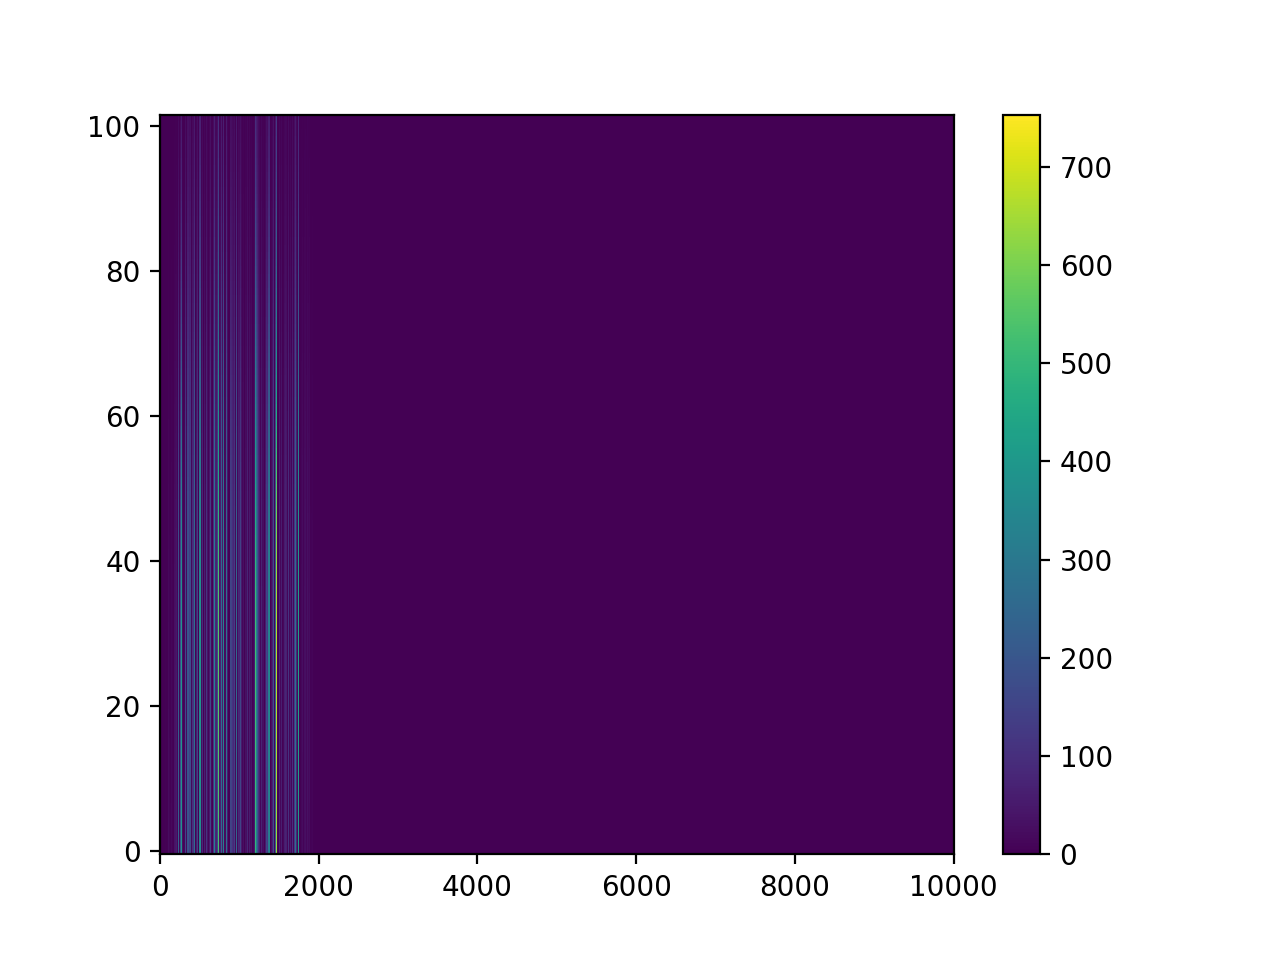

<IPython.core.display.Javascript object>


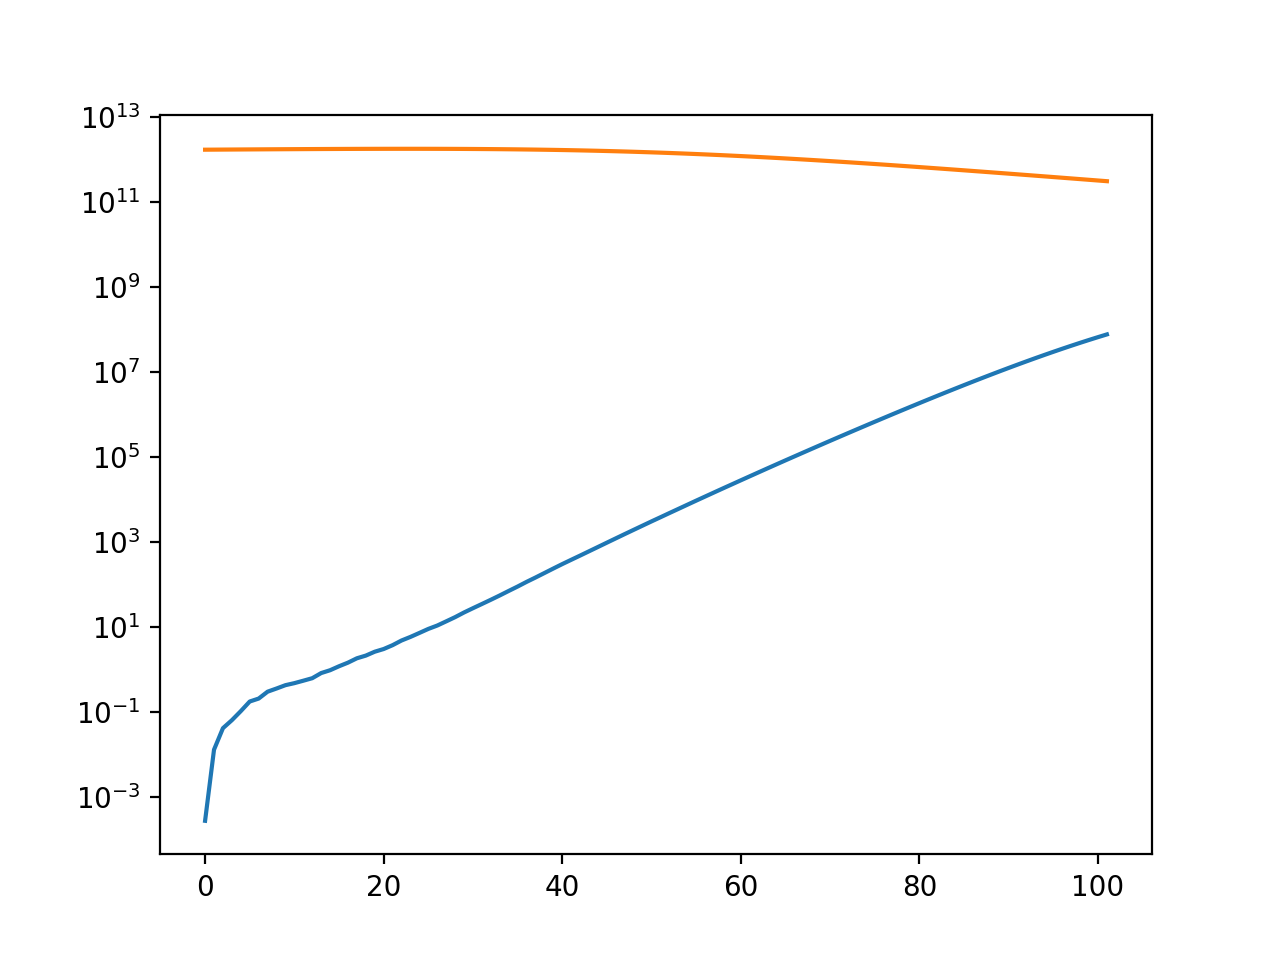

transmission 1.8e-01


In [7]:
intensity = C / (8.0*np.pi) * np.abs(fh['field'].value)**2
nph = np.sum(intensity*dt, axis=1)*rfocus**2*np.pi / OMEGA
xfel = np.sum(fh['xfel'].value*dt, axis=1)*rfocus**2*np.pi

plt.figure()
plt.imshow(intensity, origin='lower', aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(fh['xfel'].value, origin='lower', aspect='auto')
plt.colorbar()

plt.figure()
plt.plot(nph)
plt.plot(xfel)
plt.yscale('log')
print('transmission %.1e' %(xfel[-1] / xfel[0]))

In [6]:
dt = 0.01
nt = 10000
taxis = np.linspace(0, nt*dt, nt)
def plot(i):
    plt.figure()
    plt.plot(taxis, intensity[i])
    plt.xlabel('Retarded time [fs]')
    plt.xlim(0, 25)
    
ipywidgets.interact(plot, i=(0,99))

<function __main__.plot>

<IPython.core.display.Javascript object>


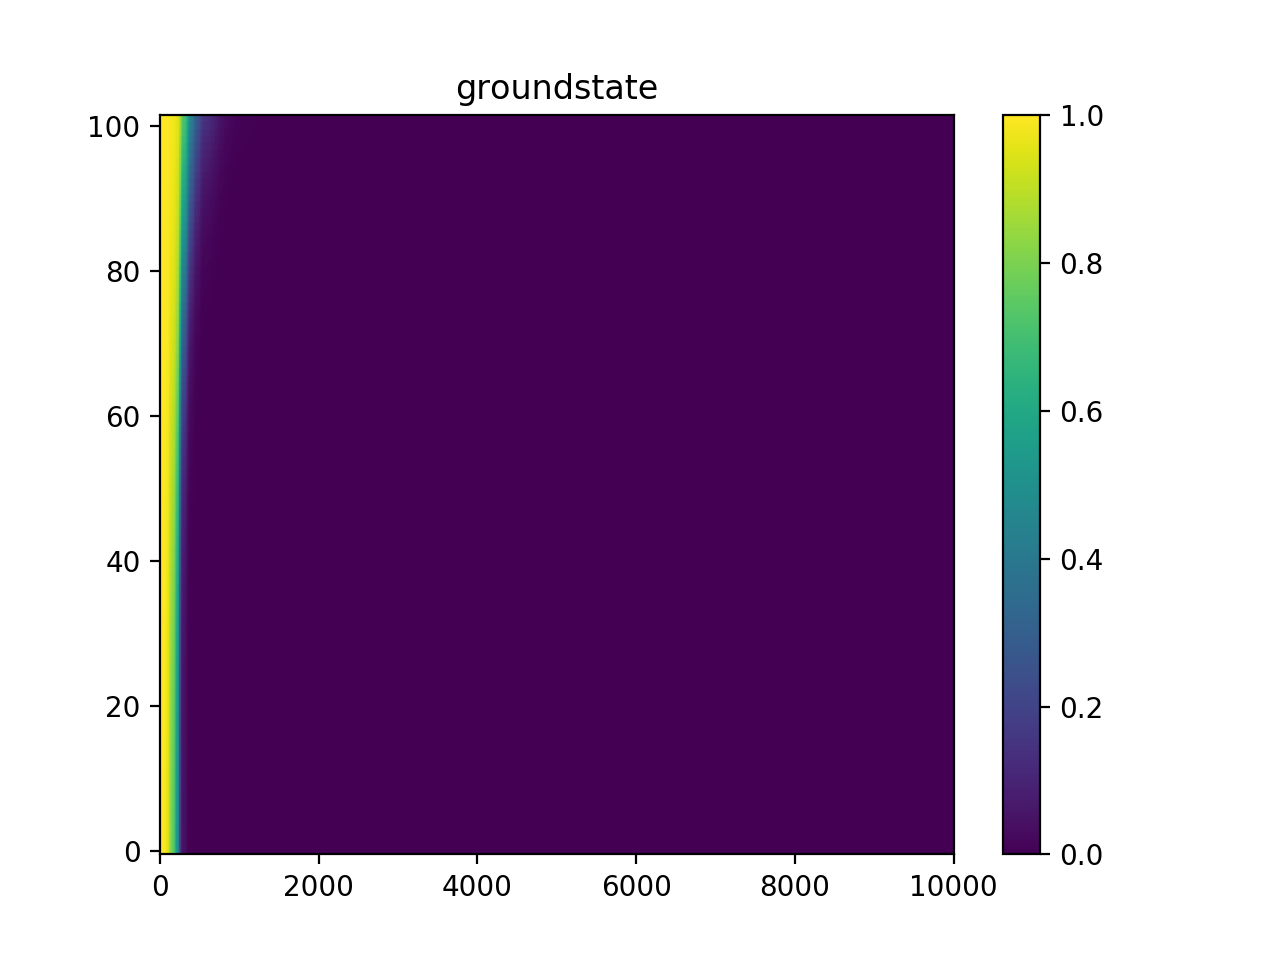

<IPython.core.display.Javascript object>


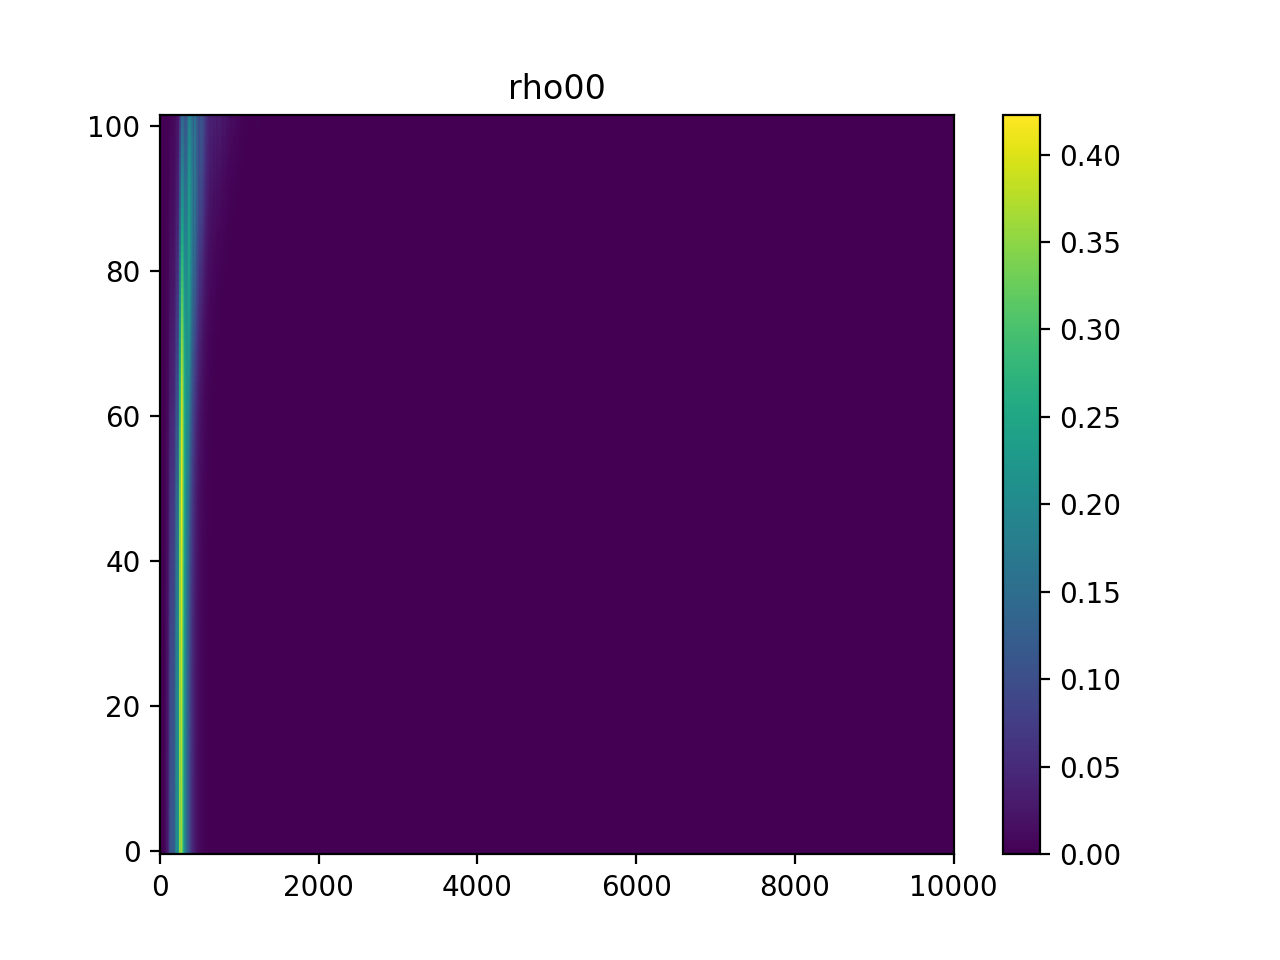

<IPython.core.display.Javascript object>


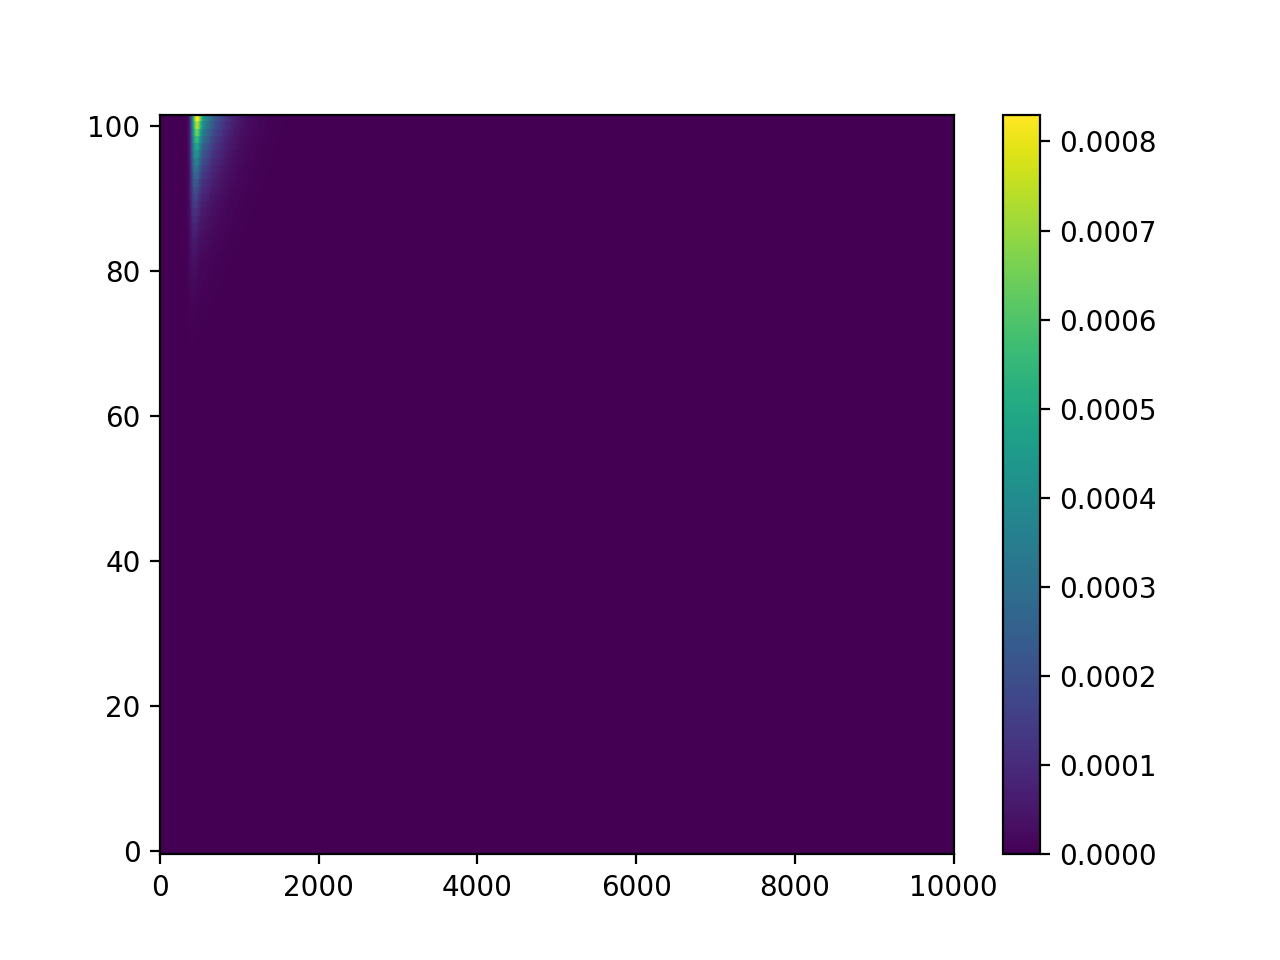

<IPython.core.display.Javascript object>


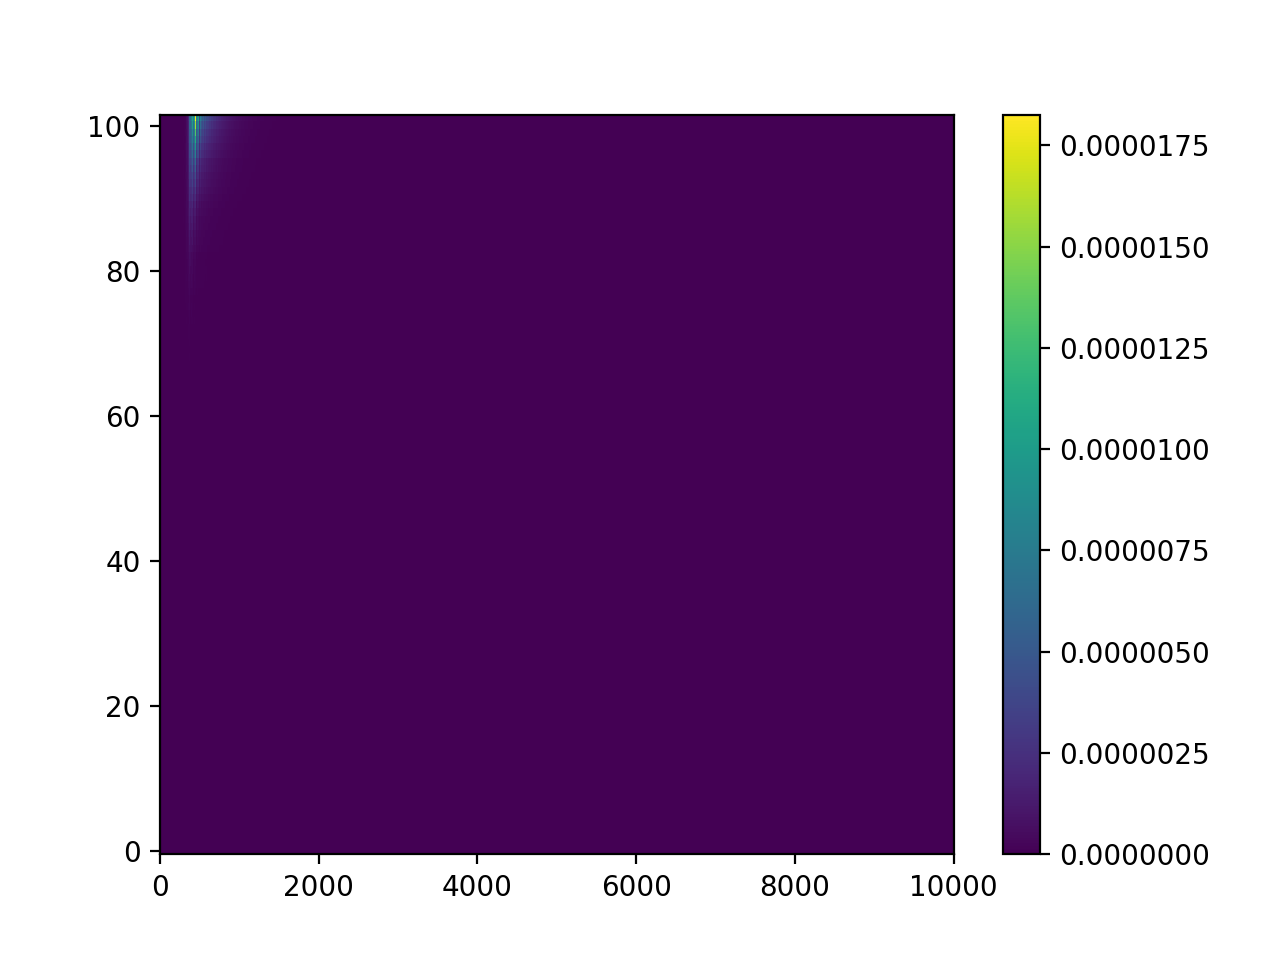

<IPython.core.display.Javascript object>


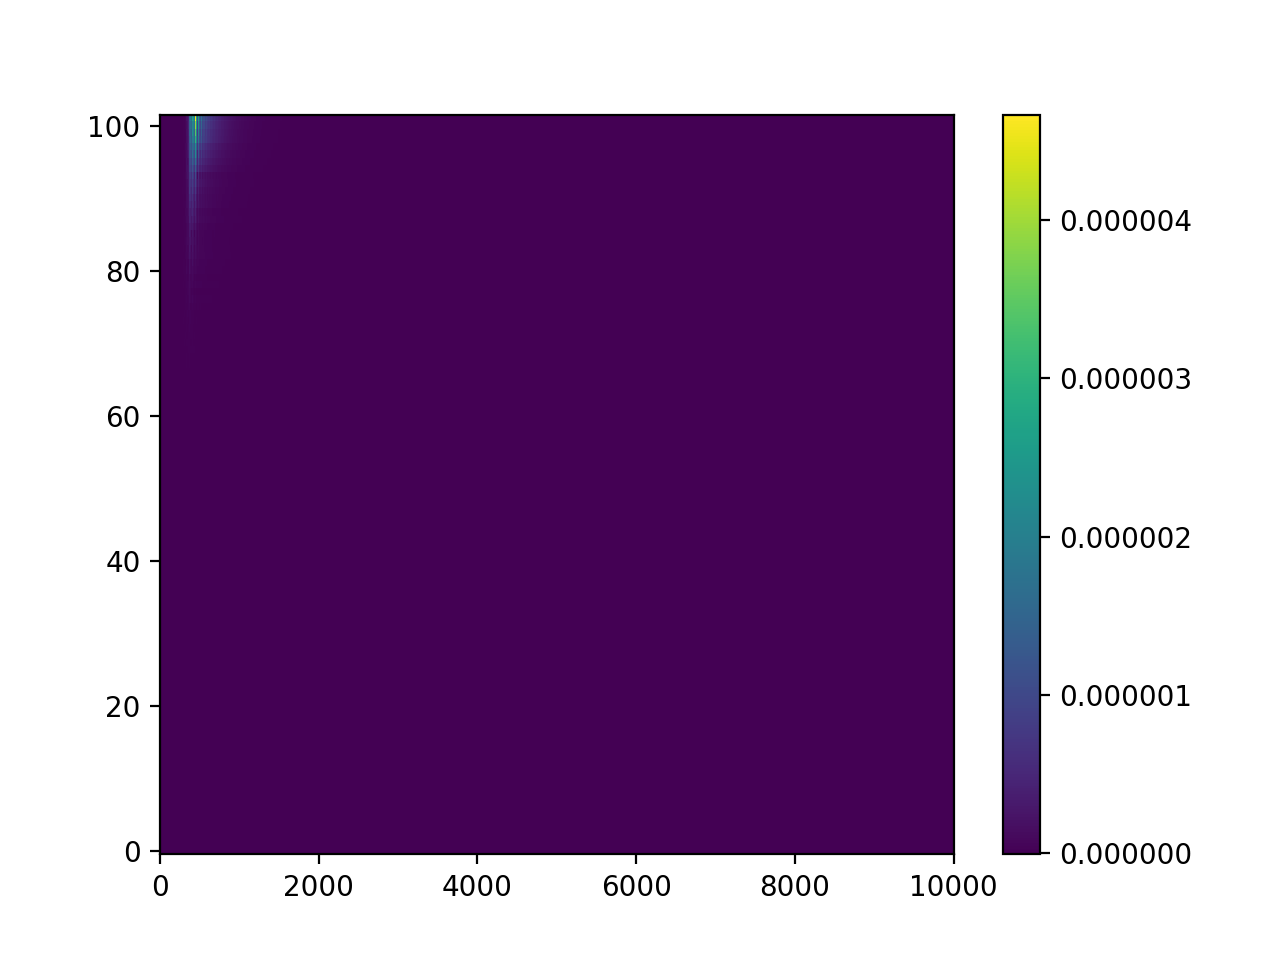

In [8]:
plt.figure()
plt.title('groundstate')
plt.imshow(fh['groundstate'].value, origin='lower', aspect='auto')
plt.colorbar()

plt.figure()
plt.title('rho00')
plt.imshow(fh['rho00'].value, origin='lower', aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(fh['rho11'].value, origin='lower', aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(fh['rho22'].value, origin='lower', aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(fh['rho33'].value, origin='lower', aspect='auto')
plt.colorbar()

<IPython.core.display.Javascript object>


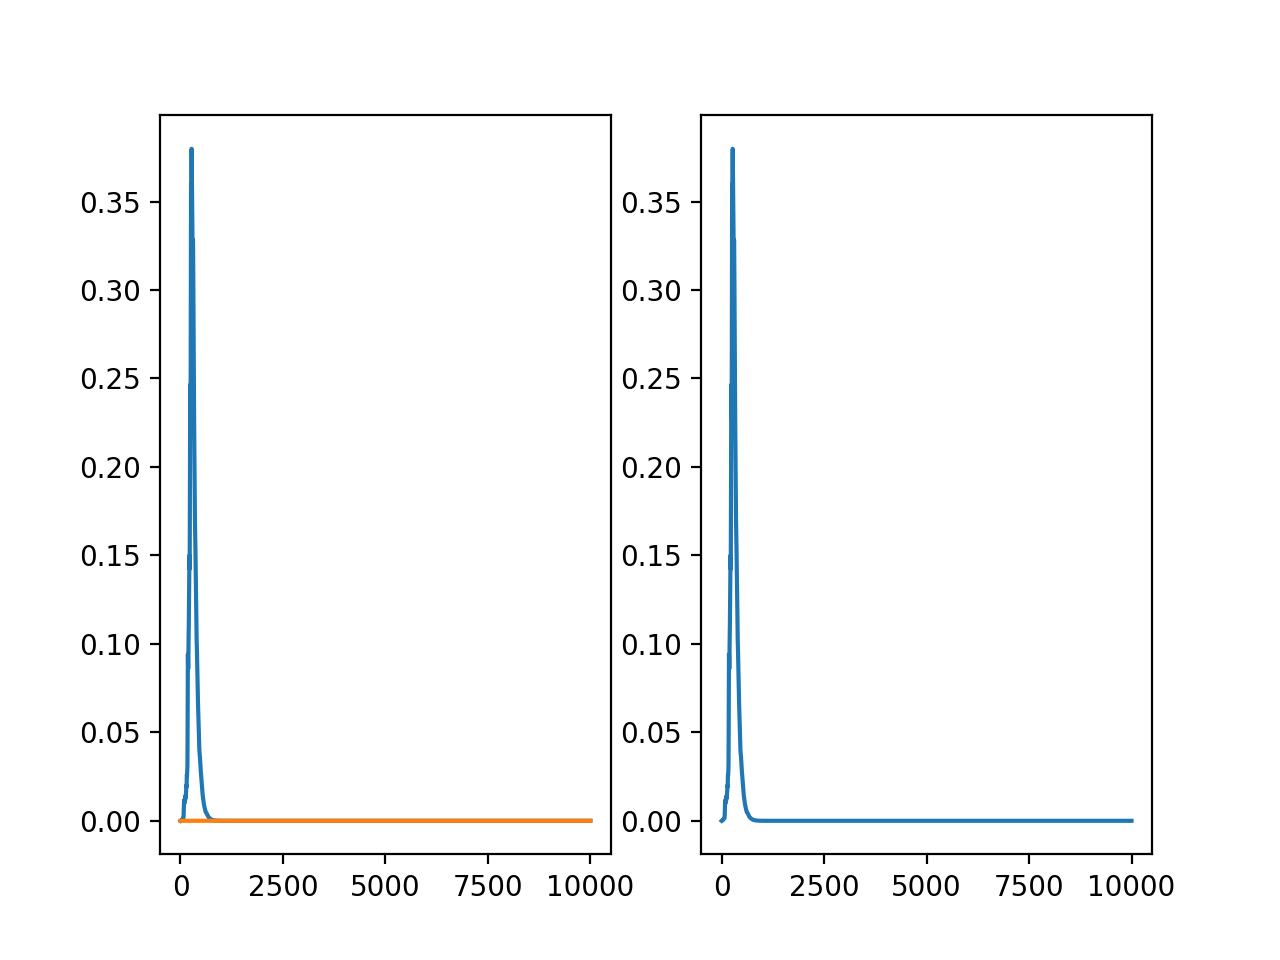

<function __main__.plot>

In [6]:
def plot(i):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(fh['rho00'].value[i])
    ax1.plot(fh['rho11'].value[i])
    #plt.plot(fh['rho22'].value[i])
    #plt.plot(fh['rho33'].value[i])
   
    ax2.plot(fh['rho00'].value[i] - fh['rho11'].value[i])
ipywidgets.interact(plot, i=(0,99))

<IPython.core.display.Javascript object>


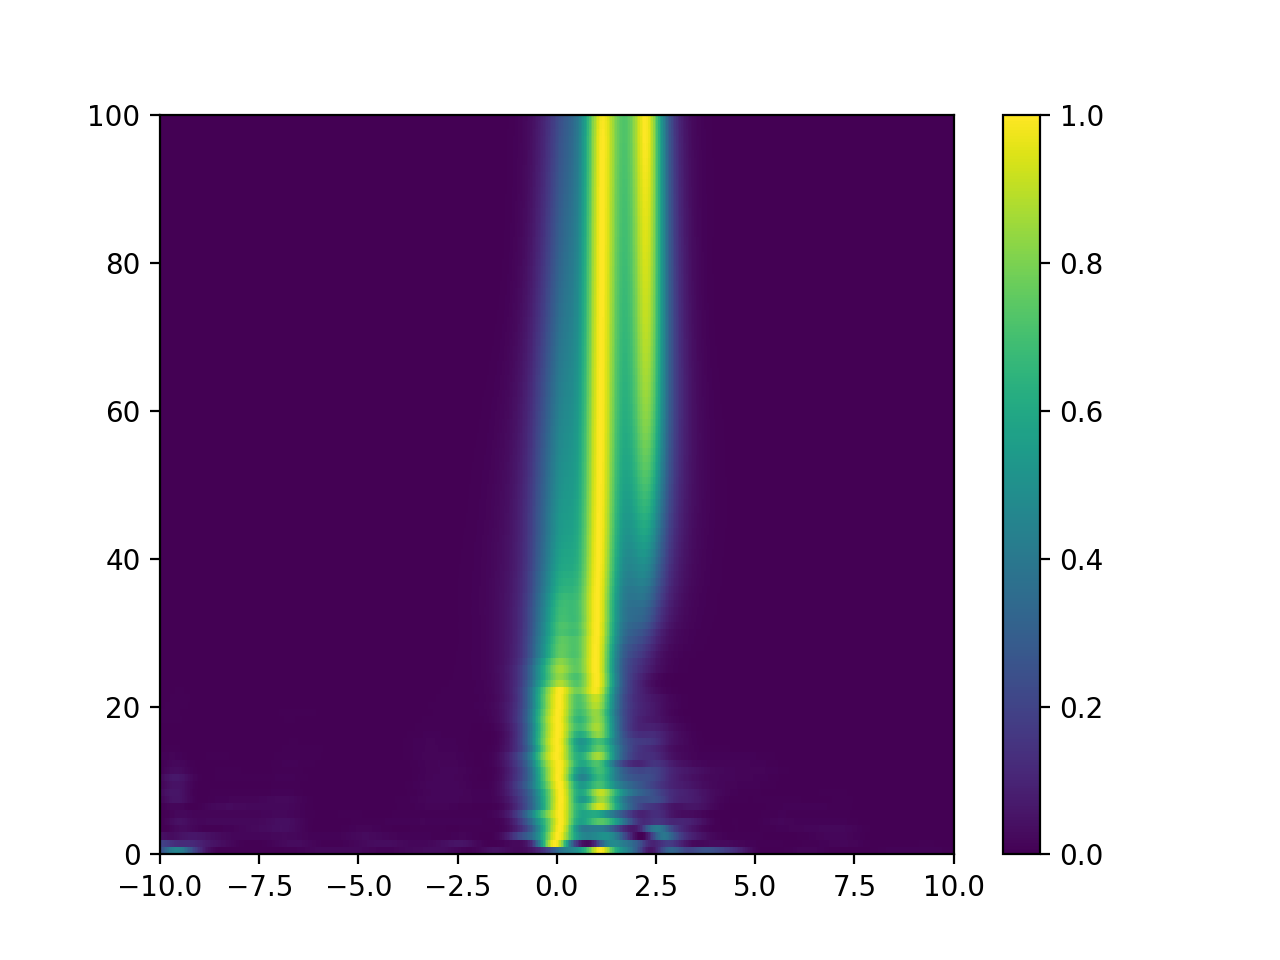

(-10.0, 10.0)

In [9]:
nt = 10000
dt = 0.01e-15 / 2.418884326505e-17
freq = np.fft.fftshift(np.fft.fftfreq(nt, dt)*2.0*np.pi*27.211)
spectrum = np.fft.fftshift(np.abs(np.fft.fft(fh['field'].value.conj(), axis=1))**2, axes=1)
plt.figure()
extent = [freq[0], freq[-1], 0, 100]
#plt.imshow(spectrum, origin='lower', aspect='auto', extent=extent)#, norm=mpl.colors.LogNorm(vmin=1.0e3))
plt.imshow(spectrum / np.amax(spectrum, axis=1, keepdims=True), origin='lower', aspect='auto', extent=extent)
plt.colorbar()
plt.xlim(-10.0, 10.0)

In [16]:
def plot(i):
    plt.figure()
    plt.plot(freq, spectrum[i])
    plt.xlim(-12.0, 10.0)
    #plt.yscale('log')
    #plt.ylim(1.0e-1)
    factor = np.amax(spectrum[i]) / np.amax(dipole)
    plt.plot(omega - omega_svea, np.array(dipole) * factor, 'o')
    
ipywidgets.interact(plot, i=(0, spectrum.shape[0]-1))

A Jupyter Widget

<function __main__.plot>

<IPython.core.display.Javascript object>


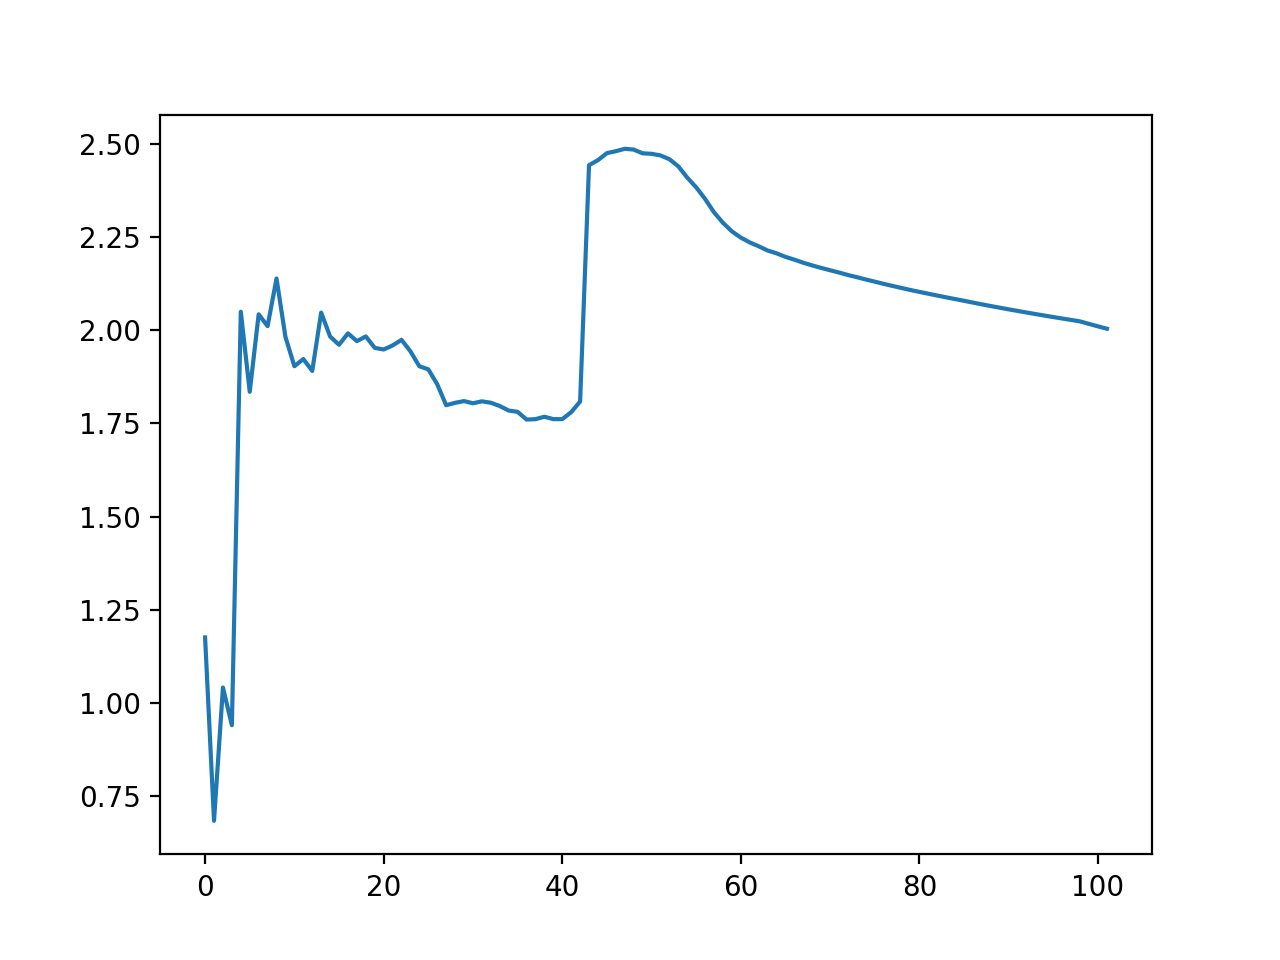

In [12]:
fwhm = [get_fwhm(freq, spec) for spec in spectrum]

plt.figure()
plt.plot(fwhm)

<IPython.core.display.Javascript object>


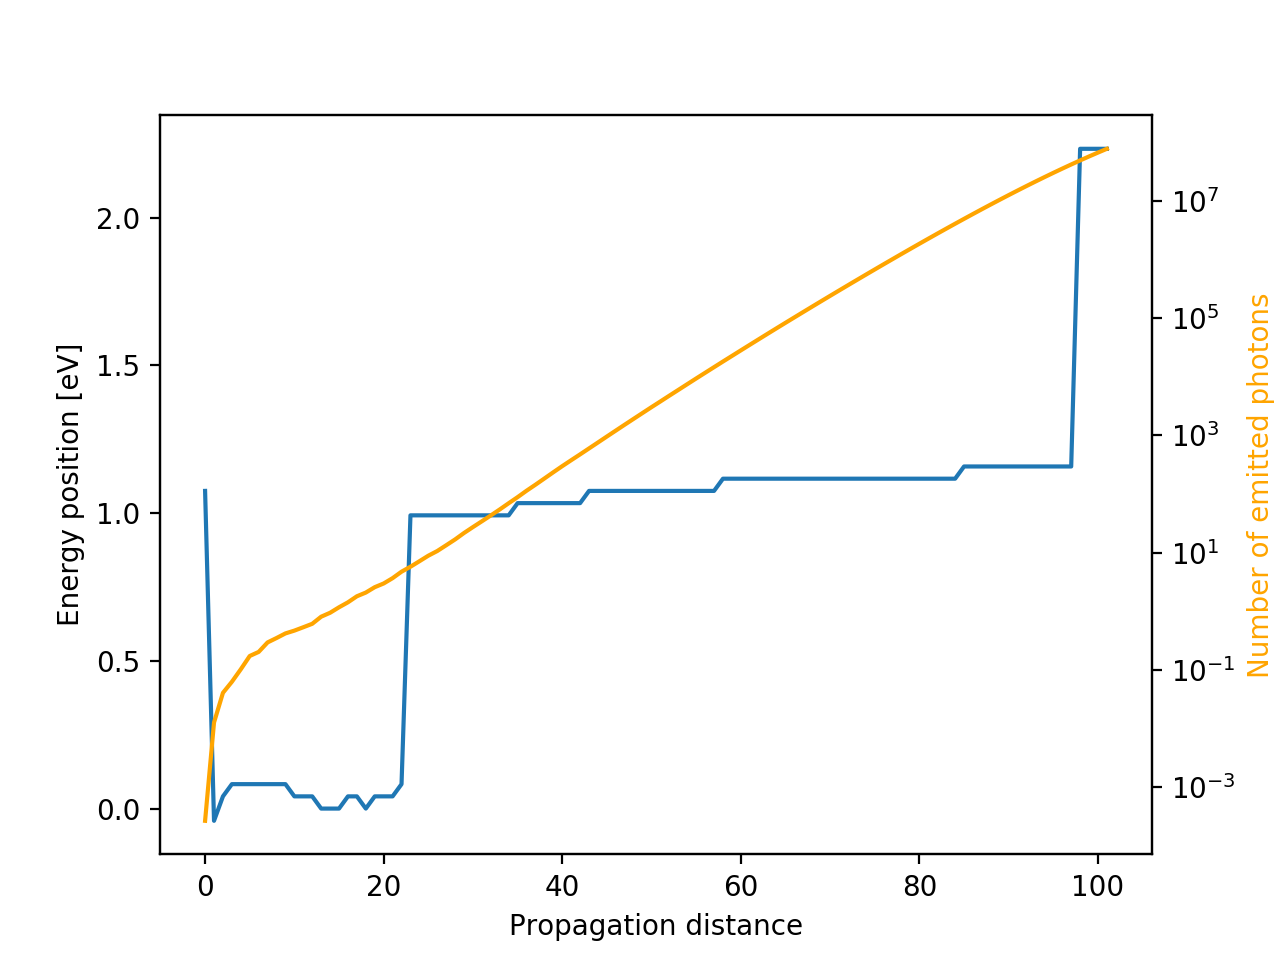

Text(0,0.5,'Number of emitted photons')

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(freq[np.argmax(spectrum, axis=1)])
ax2.plot(nph, color='orange')
ax2.set_yscale('log')
#ax2.plot(xfel)

ax1.set_xlabel('Propagation distance')
ax1.set_ylabel('Energy position [eV]')
ax2.set_ylabel('Number of emitted photons', color='orange')